<h1 ><big><center>Object recognition and computer vision 2023/2024</center></big></h1>

<h3><big><center><a href="http://imagine.enpc.fr/~varolg/">Gül Varol</a>, <a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="https://scholar.google.fr/citations?user=kRJkDakAAAAJ">Armand Joulin</a>,  <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://imagine.enpc.fr/~aubrym/">Mathieu Aubry</a></center></big></h3>


<h2><big><center> Assignment 2: Neural networks</center></big></h2>

<h5><big><center>Adapted from practicals from <a href="http://nicolas.le-roux.name/">Nicolas le Roux</a>,
  <br><a href="http://www.robots.ox.ac.uk/~vgg/practicals/overview/index.html">Andrea Vedaldi and Andrew Zisserman</a> and <a href="https://cs.nyu.edu/~fergus/teaching/vision/">Rob Fergus</a>
  <br> by <a href="https://www.di.ens.fr/~varol/">Gul Varol</a> and <a href="https://www.di.ens.fr/~iroccosp/">Ignacio Rocco</a></center></big></h5>


</br>

<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis_orig/assignment3/images/fullyconn.png"/></p>
<p align="center">Figure 1</p>
<p align="center"></p>

**STUDENT**:  Julien Delavande

**EMAIL**:  Julien.Delavande@ens-paris-saclay.fr

# Guidelines

The purpose of this assignment is that you get hands-on experience with the topics covered in class, which will help you understand these topics better. Therefore, ** it is imperative that you do this assignment yourself. No code sharing will be tolerated. **

Once you have completed the assignment, you will submit the `ipynb` file containing **both** code and results. For this, make sure to **run your notebook completely before submitting**.

The `ipynb` must be named using the following format: **A2_LASTNAME_Firstname.ipynb**, and submitted in the **class Moodle page**.

# Goal


The goal of this assignment is to get basic knowledge and hands-on experience with training and using neural networks. In Part 1 of the assignment you will implement and experiment with the training and testing of a simple two layer fully-connected neural network, similar to the one depicted in Figure 1 above. In Part 2 you will learn about convolutional neural networks, their motivation, building blocks, and how they are trained. Finally, in part 3 you will train a CNN for classification using the CIFAR-10 dataset.

# Part 1 - Training a fully connected neural network

## Getting started

You will be working with a two layer neural network of the following form

\begin{equation}
H=\text{ReLU}(W_i X+B_i)\\
Y=W_oH+B_o
\tag{1}
\end{equation}

where $X$ is the input, $Y$ is the output, $H$ is the hidden layer, and $W_i$, $W_o$, $B_i$ and $B_o$ are the network parameters that need to be trained. Here the subscripts $i$ and $o$ stand for the *input* and *output* layer, respectively. This network was also discussed in the class and is illustrated in the above figure where the input units are shown in green, the hidden units in blue and the output in yellow. This network is implemented in the function `nnet_forward_logloss`.

You will train the parameters of the network from labelled training data $\{X^n,Y^n\}$ where $X^n$ are points in $\mathbb{R}^2$ and $Y^n\in\{-1,1\}$ are labels for each point. You will use the stochastic gradient descent algorithm discussed in the class to minimize the loss of the network on the training data given by

\begin{equation}
L=\sum_n s(Y^n,\bar{Y}(X^n))
\tag{2}
\end{equation}

where $Y^n$ is the target label for the n-th example and $\bar{Y}(X^n)$ is the network’s output for the n-th example $X^n$. The skeleton of the training procedure is provided in the `train_loop` function.

We will use the logistic loss, which has the following form:

\begin{equation}
s(Y, \bar{Y}(X))=\log(1+\exp(-Y. \bar{Y}(X))
\tag{3}
\end{equation}

where $Y$ is the target label and $\bar{Y}(X)$ is the output of the network for input example $X$. With the logistic loss, the output of the network can be interpreted as a probability $P(\text{class}=1|X) =\sigma(X)$ , where $\sigma(X) =1/(1+\exp(-X))$ is the sigmoid function. Note also that $P(\text{class}=-1|X)=1-P(\text{class}=1|X)$.

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio


def decision_boundary_nnet(X, Y, Wi, bi, Wo, bo):
    x_min, x_max = -2, 4
    y_min, y_max = -5, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                     np.arange(y_min, y_max, .05))

    XX = np.vstack((xx.ravel(), yy.ravel())).T
    input_hidden = np.dot(XX, Wi) + bi
    hidden = np.maximum(input_hidden, 0)
    Z = np.dot(hidden, Wo) + bo

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z > 0, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='winter')
    plt.axis([-2, 4, -5, 3])
    plt.draw()


def sigm(x):
    # Returns the sigmoid of x.
    small_x = np.where(x < -20)  # Avoid overflows.
    sigm_x = 1/(1 + np.exp(-x))
    if type(sigm_x) is np.ndarray:
        sigm_x[small_x] = 0.0
    return sigm_x


def nnet_forward_logloss(X, Y, Wi, bi, Wo, bo):
    '''
    Compute the output Po, Yo and the loss of the network for the input X
    This is a 2 layer (1 hidden layer network)

    Input:
        X ... (in R^2) set of input points, one per column
        Y ... {-1,1} the target values for the set of points X
        Wi, bi, Wo, bo ... parameters of the network

    Output:
       Po ... probabilisitc output of the network P(class=1 | x)
                  Po is in <0 1>.
                  Note: P(class=-1 | x ) = 1 - Po
       Yo ... output of the network Yo is in <-inf +inf>
       loss ... logistic loss of the network on examples X with ground target
                    values Y in {-1,1}
    '''
    # Hidden layer
    hidden = np.maximum(np.dot(X, Wi) + bi, 0)
    # Output of the network
    Yo = np.dot(hidden, Wo) + bo
    # Probabilistic output
    Po = sigm(Yo)
    # Logistic loss
    loss = np.log(1 + np.exp( -Y * Yo))
    return Po, Yo, loss


# Load the training data
!wget -q http://www.di.ens.fr/willow/teaching/recvis_orig/assignment2/double_moon_train1000.mat
train_data = sio.loadmat('./double_moon_train1000.mat', squeeze_me=True)
Xtr = train_data['X']
Ytr = train_data['Y']
# Load the validation data
!wget -q http://www.di.ens.fr/willow/teaching/recvis_orig/assignment2/double_moon_val1000.mat
val_data = sio.loadmat('./double_moon_val1000.mat', squeeze_me=True)
Xval = val_data['X']
Yval = val_data['Y']

## Computing gradients of the loss with respect to network parameters

### :: TASK 1.1 ::
Derive the form of the gradient of the logistic loss (3) with respect to the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$.  *Hint:* Use the chain rule as discussed in the class.

######################

### Step 1: Compute the Gradient with Respect to $ W_o$ and $ B_o $

1. **Loss with respect to output $ \bar{Y}(X) $**:
   $$
   \frac{\partial s}{\partial \bar{Y}(X)} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))} \exp(Y \cdot \bar{Y}(X)) = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))}
   $$

2. **Output with respect to $ W_o $**:
   Since $ \bar{Y}(X) = W_o H + B_o $,
   $$
   \frac{\partial \bar{Y}(X)}{\partial W_o} = H
   $$
   Thus, by chain rule,
   $$
   \frac{\partial s}{\partial W_o} = \frac{\partial s}{\partial \bar{Y}(X)} \cdot \frac{\partial \bar{Y}(X)}{\partial W_o} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))} H
   $$

3. **Output with respect to $ B_o $**:
   $$
   \frac{\partial \bar{Y}(X)}{\partial B_o} = 1
   $$
   Thus,
   $$
   \frac{\partial s}{\partial B_o} = \frac{\partial s}{\partial \bar{Y}(X)} \cdot \frac{\partial \bar{Y}(X)}{\partial B_o} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))}
   $$

### Step 2: Compute the Gradient with Respect to $ W_i $ and $ B_i $

1. **Output with respect to $ H $**:
   $$
   \frac{\partial \bar{Y}(X)}{\partial H} = W_o
   $$

2. **Hidden Layer Activation with respect to $ W_i $**:

   Since $ H = \text{ReLU}(W_i X + B_i) $, we apply the chain rule:
   $$
   \frac{\partial H}{\partial W_i} = X \cdot \mathbb{1}_{W_i X + B_i > 0}
   $$
   where $ \mathbb{1}_{W_i X + B_i > 0} $ is the indicator function for the ReLU.

   Thus,
   $$
   \frac{\partial s}{\partial W_i} = \frac{\partial s}{\partial \bar{Y}(X)} \cdot \frac{\partial \bar{Y}(X)}{\partial H} \cdot \frac{\partial H}{\partial W_i} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))} W_o X \cdot \mathbb{1}_{W_i X + B_i > 0}
   $$

3. **Hidden Layer Activation with respect to $ B_i $**:

   Similarly,
   $$
   \frac{\partial H}{\partial B_i} = \mathbb{1}_{W_i X + B_i > 0}
   $$
   Thus,
   $$
   \frac{\partial s}{\partial B_i} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))} W_o \cdot \mathbb{1}_{W_i X + B_i > 0}
   $$

### Summary of Gradients
The gradients of the logistic loss with respect to the parameters are as follows:

$$
\frac{\partial s}{\partial W_o} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))} H
$$
$$
\frac{\partial s}{\partial B_o} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))}
$$
$$
\frac{\partial s}{\partial W_i} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))} W_o X \cdot \mathbb{1}_{W_i X + B_i > 0}
$$
$$
\frac{\partial s}{\partial B_i} = -\frac{Y}{1 + \exp(Y \cdot \bar{Y}(X))} W_o \cdot \mathbb{1}_{W_i X + B_i > 0}
$$

######################

### :: TASK 1.2 ::

Following your derivation, implement the gradient computation in the function `gradient_nn`. See the code for the description of the required inputs / outputs of this function.

In [2]:
def gradient_nn(X, Y, Wi, bi, Wo, bo):
    '''
    Compute gradient of the logistic loss of the neural network on example X with
    target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
        X ... 2d vector of the input example
        Y ... the target label in {-1,1}
        Wi,bi,Wo,bo ... parameters of the network
        Wi ... [dxh]
        bi ... [h]
        Wo ... [h]
        bo ... 1
        where h... is the number of hidden units
              d... is the number of input dimensions (d=2)

    Output:
        grad_s_Wi [dxh] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
        grad_s_bi [h]   ... gradient of loss s(Y,Y(X)) w.r.t. bi
        grad_s_Wo [h]   ... gradient of loss s(Y,Y(X)) w.r.t. Wo
        grad_s_bo 1     ... gradient of loss s(Y,Y(X)) w.r.t. bo
    '''



    ##########################
    # grad_s_Wi = np.outer(X, grad_H)
    # grad_s_bi = grad_H
    # grad_s_Wo = loss_grad_YX * H
    # grad_s_bo = loss_grad_YX
    ##########################

    H_pre = np.dot(X, Wi) + bi
    H = np.maximum(H_pre, 0)

    Y_X = np.dot(H, Wo) + bo

    loss_grad_YX = -Y / (1 + np.exp(Y * Y_X))

    grad_s_Wo = loss_grad_YX * H
    grad_s_bo = loss_grad_YX

    grad_H = loss_grad_YX * Wo
    grad_H[H_pre <= 0] = 0

    grad_s_Wi = np.outer(X, grad_H)
    grad_s_bi = grad_H

    return grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo

    ##########################

## Numerically verify the gradients
Here you will numerically verify that your analytically computed gradients in function `gradient_nn` are correct.

### :: TASK 1.3 ::
Write down the general formula for numerically computing the approximate derivative of the loss $s(\theta)$, with respect to the parameter $\theta_i$ using finite differencing.  *Hint: use the first order Taylor expansion of loss $s(\theta+\Delta \theta)$ around point $\theta$. *

######################

Using Taylor expansion, we get:
$$
s(\theta + \Delta \theta) \approx s(\theta) + \frac{\partial s}{\partial \theta_i} \Delta \theta
$$

Rearranging, the numerical approximation of the derivative with respect to $ \theta_i $ is:
$$
\frac{\partial s}{\partial \theta_i} \approx \frac{s(\theta + \Delta \theta_i) - s(\theta)}{\Delta \theta_i}
$$

where:
- $ \Delta \theta_i $ is a small increment applied only to $ \theta_i $, keeping other parameters fixed.



######################

Following the general formula, `gradient_nn_numerical` function numerically computes the derivatives of the loss function with respect to all the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$:

In [3]:
def gradient_nn_numerical(X, Y, Wi, bi, Wo, bo):
    '''
    Compute numerical gradient of the logistic loss of the neural network on
    example X with target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
       X ... 2d vector of the input example
       Y ... the target label in {-1,1}
       Wi, bi, Wo, bo ... parameters of the network
       Wi ... [dxh]
       bi ... [h]
       Wo ... [h]
       bo ... 1
       where h... is the number of hidden units
             d... is the number of input dimensions (d=2)

    Output:
       grad_s_Wi_numerical [dxh] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
       grad_s_bi_numerical [h]   ... gradient of loss s(Y,Y(X)) w.r.t. bi
       grad_s_Wo_numerical [h]   ... gradient of loss s(Y,Y(X)) w.r.t. Wo
       grad_s_bo_numerical 1     ... gradient of loss s(Y,Y(X)) w.r.t. bo
    '''

    eps = 1e-8
    grad_s_Wi_numerical = np.zeros(Wi.shape)
    grad_s_bi_numerical = np.zeros(bi.shape)
    grad_s_Wo_numerical = np.zeros(Wo.shape)

    for i in range(Wi.shape[0]):
        for j in range(Wi.shape[1]):
            dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, sumelement_matrix(Wi, i, j, +eps), bi, Wo, bo)
            dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, sumelement_matrix(Wi, i, j, -eps), bi, Wo, bo)
            grad_s_Wi_numerical[i, j] = (pos_loss - neg_loss)/(2*eps)

    for i in range(bi.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, sumelement_vector(bi, i, +eps), Wo, bo)
        dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, sumelement_vector(bi, i, -eps), Wo, bo)
        grad_s_bi_numerical[i] = (pos_loss - neg_loss)/(2*eps)

    for i in range(Wo.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, sumelement_vector(Wo, i, +eps), bo)
        dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, sumelement_vector(Wo, i, -eps), bo)
        grad_s_Wo_numerical[i] = (pos_loss - neg_loss)/(2*eps)

    dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo+eps)
    dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo-eps)
    grad_s_bo_numerical = (pos_loss - neg_loss)/(2*eps)

    return grad_s_Wi_numerical, grad_s_bi_numerical, grad_s_Wo_numerical, grad_s_bo_numerical


def sumelement_matrix(X, i, j, element):
    Y = np.copy(X)
    Y[i, j] = X[i, j] + element
    return Y


def sumelement_vector(X, i, element):
    Y = np.copy(X)
    Y[i] = X[i] + element
    return Y

### :: TASK 1.4 ::

Run the following code snippet and understand what it is doing. `gradcheck` function checks that the analytically computed derivative using function `gradient_nn` (e.g. `grad_s_bo`) at the same training example $\{X,Y\}$ is the same (up to small errors) as your numerically computed value of the derivative using function `gradient_nn_numerical` (e.g. `grad_s_bo_numerical`). Make sure the output is `SUCCESS` to move on to the next task.

In [4]:
def gradcheck():
    '''
    Check that the numerical and analytical gradients are the same up to eps
    '''
    h = 3 # number of hidden units
    eps = 1e-6
    for i in range(1000):
        # Generate random input/output/weight/bias
        X  = np.random.randn(2)
        Y  = 2* np.random.randint(2) - 1 # {-1, 1}
        Wi = np.random.randn(X.shape[0], h)
        bi = np.random.randn(h)
        Wo = np.random.randn(h)
        bo = np.random.randn(1)
        # Compute analytical gradients
        grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)
        # Compute numerical gradients
        grad_s_Wi_numerical, grad_s_bi_numerical, grad_s_Wo_numerical, grad_s_bo_numerical = gradient_nn_numerical(X, Y, Wi, bi, Wo, bo)
        # Compute the difference between analytical and numerical gradients
        delta_Wi = np.mean(np.abs(grad_s_Wi - grad_s_Wi_numerical))
        delta_bi = np.mean(np.abs(grad_s_bi - grad_s_bi_numerical))
        delta_Wo = np.mean(np.abs(grad_s_Wo - grad_s_Wo_numerical))
        delta_bo = np.abs(grad_s_bo - grad_s_bo_numerical)
        # Difference larger than a threshold
        if ( delta_Wi > eps or delta_bi > eps or delta_Wo > eps or delta_bo > eps):
            return False

    return True


# Check gradients
if gradcheck():
    print('SUCCESS: Passed gradcheck.')
else:
    print('FAILURE: Fix gradient_nn and/or gradient_nn_aprox implementation.')

<ipython-input-3-73f95023ff68>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad_s_Wi_numerical[i, j] = (pos_loss - neg_loss)/(2*eps)
<ipython-input-3-73f95023ff68>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad_s_bi_numerical[i] = (pos_loss - neg_loss)/(2*eps)
<ipython-input-3-73f95023ff68>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad_s_Wo_numerical[i] = (pos_loss - neg_loss)/(2*eps)


SUCCESS: Passed gradcheck.


## Training the network using backpropagation and experimenting with different parameters

Use the provided code below that calls the `train_loop` function. Set the number of hidden units to 7 by setting $h=7$ in the code and set the learning rate to 0.02 by setting `lrate = 0.02`. Run the training code. Visualize the trained hyperplane using the provided function `plot_decision_boundary(Xtr,Ytr,Wi,bi,Wo,bo)`. Show also the evolution of the training and validation errors. Include the decision hyper-plane visualization and the training and validation error plots.

In [7]:
def train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='all', nEpochs=100):
    '''
    Check that the numerical and analytical gradients are the same up to eps

    Input:
        Xtr ... Nx2 matrix of training samples
        Ytr ... N dimensional vector of training labels
        Xval ... Nx2 matrix of validation samples
        Yval ... N dimensional vector validation labels
        h ... number of hidden units
        lrate ... learning rate
        vis ... visulaization option ('all' | 'last' | 'never')
        nEpochs ... number of training epochs

    Output:
        tr_error ... nEpochs*nSamples dimensional vector of training error
        val_error ... nEpochs*nSamples dimensional vector of validation error
    '''

    nSamples = Xtr.shape[0]
    tr_error = np.zeros(nEpochs*nSamples)
    val_error = np.zeros(nEpochs*nSamples)

    # Randomly initialize parameters of the model
    Wi = np.random.randn(Xtr.shape[1], h)
    Wo = np.zeros(h)
    bi = np.zeros(h)
    bo = 0.

    if(vis == 'all' or vis == 'last'):
        plt.figure()

    for i in range(nEpochs*nSamples):
        # Draw an example at random
        n = np.random.randint(nSamples)
        X = Xtr[n]
        Y = Ytr[n]

        # Compute gradient
        grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)

        # Gradient update
        Wi -= lrate*grad_s_Wi
        Wo -= lrate*grad_s_Wo
        bi -= lrate*grad_s_bi
        bo -= lrate*grad_s_bo

        # Compute training error
        Po, Yo, loss    = nnet_forward_logloss(Xtr, Ytr, Wi, bi, Wo, bo)
        Yo_class        = np.sign(Yo)
        tr_error[i]     = 100*np.mean(Yo_class != Ytr)

        # Compute validation error
        Pov, Yov, lossv = nnet_forward_logloss(Xval, Yval, Wi, bi, Wo, bo)
        Yov_class       = np.sign(Yov)
        val_error[i]    = 100*np.mean(Yov_class != Yval)

        # Plot (at every epoch if visualization is 'all', only at the end if 'last')
        if(vis == 'all' and i%nSamples == 0) or (vis == 'last' and i == nEpochs*nSamples - 1):
            # Draw the decision boundary.
            plt.clf()
            plt.title('p = %d, Iteration = %.d, Error = %.3f' % (h, i/nSamples, tr_error[i]))
            decision_boundary_nnet(Xtr, Ytr, Wi, bi, Wo, bo)
            display.display(plt.gcf(), display_id=True)
            display.clear_output(wait=True)

    if(vis == 'all'):
        # Plot the evolution of the training and test errors
        plt.figure()
        plt.plot(tr_error, label='training')
        plt.plot(val_error, label='validation')
        plt.legend()
        plt.title('Training/validation errors: %.2f%% / %.2f%%' % (tr_error[-1], val_error[-1]))
    return tr_error, val_error

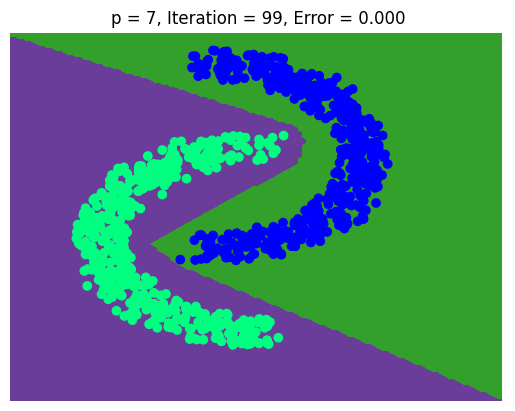

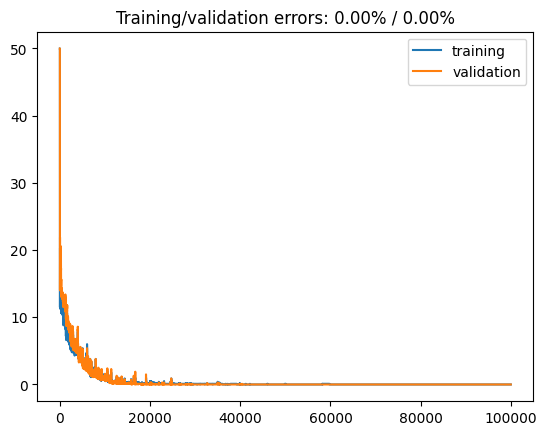

In [8]:
# Run training
h = 7
lrate = .02
tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate)

### :: TASK 1.6 ::

**Random initializations.** Repeat this procedure 5 times from 5 different random initializations. Record for each run the final training and validation errors. Did the network always converge to zero training error? Summarize your final training and validation errors into a table for the 5 runs. You do not need to include the decision hyper-plane visualizations. Note: to speed-up the training you can plot the visualization figures less often (or never) and hence speed-up the training.

Summary of Training and Validation Errors for 5 Random Initializations:


,Run,Training Error,Validation Error,Final Training Error,Final Validation Error
0,1,"[50.0, 17.599999999999998, 14.099999999999998,...","[50.0, 20.0, 16.1, 21.5, 21.9, 18.8, 19.6, 20....",0.0,0.0
1,2,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....",0.0,0.0
2,3,"[50.0, 29.099999999999998, 26.8, 25.6, 24.8, 2...","[50.0, 33.0, 30.7, 28.799999999999997, 28.4, 2...",0.0,0.0
3,4,"[50.0, 19.8, 15.2, 29.7, 48.5, 17.8, 14.7, 22....","[50.0, 22.1, 16.6, 31.8, 48.8, 20.3, 16.3, 24....",0.0,0.0
4,5,"[50.0, 50.0, 50.0, 50.0, 50.0, 28.000000000000...","[50.0, 50.0, 50.0, 50.0, 50.0, 29.2, 50.0, 50....",0.0,0.0


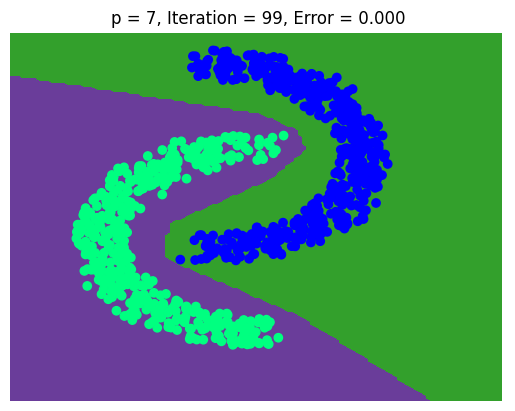

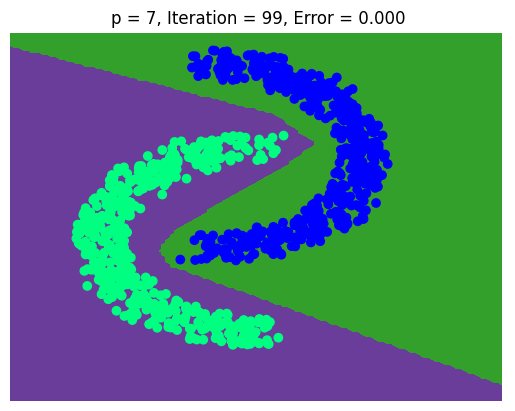

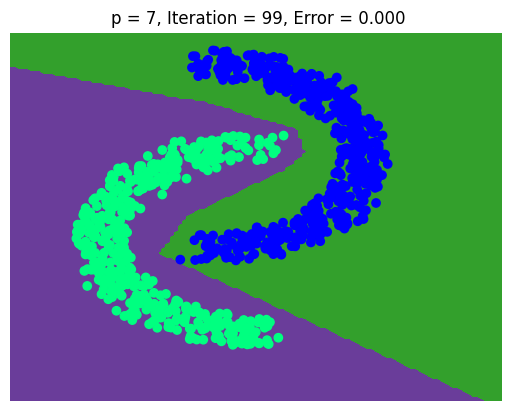

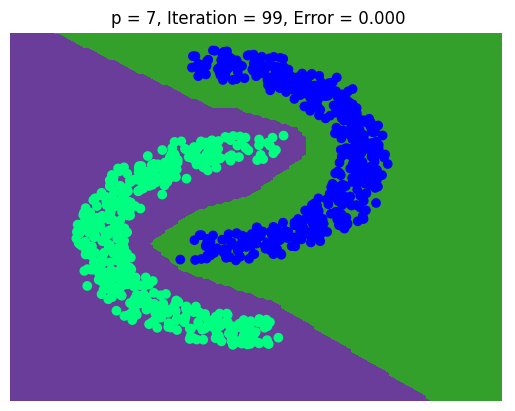

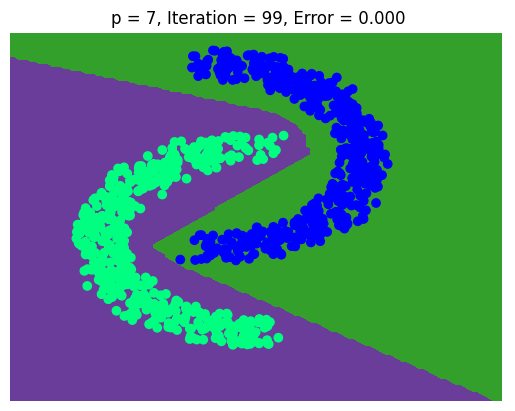

In [9]:
##########################

h = 7          # Number of hidden units
lrate = 0.02   # Learning rate
num_runs = 5   # Number of different initializations

training_errors = []
validation_errors = []

for i in range(num_runs):
    final_train_error, final_val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='last')

    training_errors.append(final_train_error)
    validation_errors.append(final_val_error)

import pandas as pd

results_df = pd.DataFrame({
    "Run": range(1, num_runs + 1),
    "Training Error": training_errors,
    "Validation Error": validation_errors,
    "Final Training Error": [error[-1] for error in training_errors],
    "Final Validation Error": [error[-1] for error in validation_errors]
})

print("Summary of Training and Validation Errors for 5 Random Initializations:")
results_df

##########################

######################

### Results Summary

| Run | Final Training Error | Final Validation Error |
|-----|-----------------------|------------------------|
|  1  |        0.00          |         0.00          |
|  2  |        0.00          |         0.00          |
|  3  |        0.00          |         0.00          |
|  4  |        0.00          |         0.00          |
|  5  |        0.00          |         0.00          |

**Did the network always converge to zero training error?**

Yes, the network consistently converged to zero training error for each run, regardless of the random initialization of weights.

######################

### :: SAMPLE TASK ::

For this task, the answer is given. Run the given code and answer Task 1.8 similarly.

**Learning rate:**

Keep $h=7$ and change the learning rate to values $\text{lrate} = \{2, 0.2, 0.02, 0.002\}$. For each of these values run the training procedure 5 times and observe the training behaviour. You do not need to include the decision hyper-plane visualizations in your answer.

**- Make one figure** where *final* error for (i) training and (ii) validation sets are superimposed. $x$-axis should be the different values of the learning rate, $y$-axis the error *mean* across 5 runs. Show the standard deviation with error bars and make sure to label each plot with a legend.

**- Make another figure** where *training error evolution* for each learning rate is superimposed. $x$-axis should be the iteration number, $y$-axis the training error *mean* across 5 runs for a given learning rate. Show the standard deviation with error bars and make sure to label each curve with a legend.

In [10]:
nEpochs = 40
trials = 5
lrates = [2, 0.2, 0.02, 0.002]
plot_data_lr = np.zeros((2, trials, len(lrates), nEpochs*1000))
h = 7
for j, lrate in enumerate(lrates):
    print('LR = %f' % lrate)
    for i in range(trials):
        tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='never', nEpochs=nEpochs)
        plot_data_lr[0, i, j, :] = tr_error
        plot_data_lr[1, i, j, :] = val_error

LR = 2.000000


<ipython-input-1-04b2a96754fd>:63: RuntimeWarning: overflow encountered in exp
  loss = np.log(1 + np.exp( -Y * Yo))
<ipython-input-1-04b2a96754fd>:32: RuntimeWarning: overflow encountered in exp
  sigm_x = 1/(1 + np.exp(-x))
<ipython-input-2-9df765b689f7>:38: RuntimeWarning: overflow encountered in exp
  loss_grad_YX = -Y / (1 + np.exp(Y * Y_X))


LR = 0.200000
LR = 0.020000
LR = 0.002000


Text(0, 0.5, 'training error')

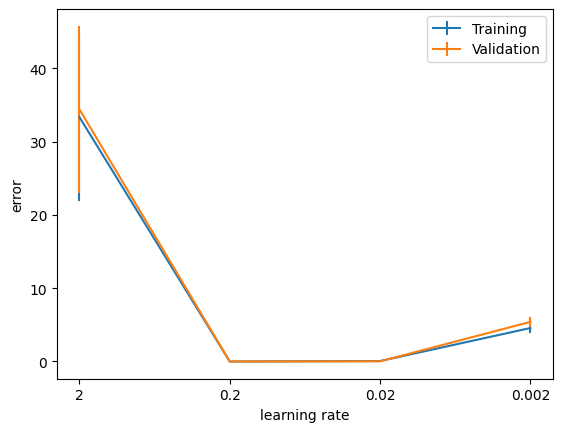

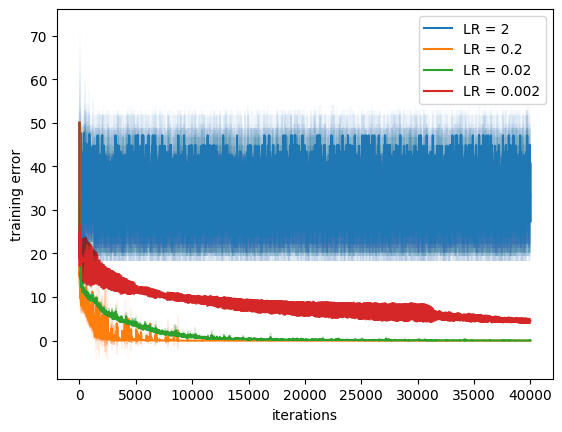

In [11]:
plt.errorbar(np.arange(len(lrates)), plot_data_lr[0, :, :, -1].mean(axis=0), yerr=plot_data_lr[0, :, :, -1].std(axis=0), label='Training')
plt.errorbar(np.arange(len(lrates)), plot_data_lr[1, :, :, -1].mean(axis=0), yerr=plot_data_lr[0, :, :, -1].std(axis=0), label='Validation')
plt.xticks(np.arange(len(lrates)), lrates)
plt.xlabel('learning rate')
plt.ylabel('error')
plt.legend()

# Plot the evolution of the training loss for each learning rate
plt.figure()
for j, lrate in enumerate(lrates):
    x = np.arange(plot_data_lr.shape[3])
    # Mean training loss over trials
    y = plot_data_lr[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_lr[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label='LR = ' + str(lrate))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel('iterations')
plt.ylabel('training error')

### :: TASK 1.7 ::

**- Briefly discuss** the different behaviour of the training for different learning rates. How many iterations does it take to converge or does it converge at all? Which learning rate is  better and why?

######################

### Learning Rate Comparison

| Learning Rate | Behavior                      | Convergence Speed | Stability   |
|---------------|-------------------------------|-------------------|-------------|
| 2             | Unstable, likely divergence   | Very fast (if stable) | Low        |
| 0.2           | Fast convergence, may overshoot | Fast          | Moderate    |
| 0.02          | Smooth and steady convergence | Moderate       | High        |
| 0.002         | Very slow, stable             | Slow           | Very High   |

### Summary
- **Best Learning Rate**: **0.02** strikes a balance between stability and speed, providing steady convergence without oscillations.
- **Learning Rate 2** often diverges, while **0.002** is very slow but stable.
- **0.2** is faster but may overshoot, making **0.02** the ideal choice overall.


######################

### :: TASK 1.8 ::
**The number of hidden units:**

Set the learning rate to 0.02 and change the number of hidden units $h = \{1, 2, 5, 7, 10, 100\}$. For each of these values run the training procedure 5 times and observe the training behaviour

**-Visualize** one decision hyper-plane per number of hidden units.

**-Make one figure** where *final* error for (i) training and (ii) validation sets are superimposed. $x$-axis should be the different values of the number of hidden units, $y$-axis the error *mean* across 5 runs. Show the standard deviation with error bars and make sure to label each plot with a legend.

**-Make another figure** where *training error evolution* for each number of hidden units is superimposed. $x$-axis should be the iteration number, $y$-axis the training error *mean* across 5 runs for a given learning rate. Show the standard deviation with error bars and make sure to label each curve with a legend.

**-Briefly discuss** the different behaviours for the different numbers of hidden units.

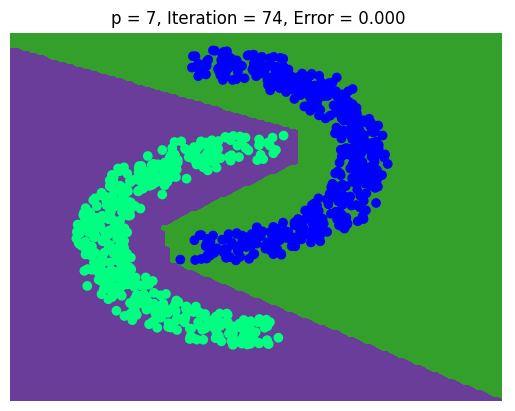

In [ ]:
##########################
lrate = 0.02
num_runs = 5
hidden_units = [1, 2, 5, 7, 10, 100]

train_errors = {h: [] for h in hidden_units}
val_errors = {h: [] for h in hidden_units}
train_error_evolution = {h: [] for h in hidden_units}

for h in hidden_units:
    for _ in range(num_runs):

        tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate)

        train_errors[h].append(tr_error[-1])
        val_errors[h].append(val_error[-1])

        train_error_evolution[h].append(tr_error)

train_mean_errors = [np.mean(train_errors[h]) for h in hidden_units]
train_std_errors = [np.std(train_errors[h]) for h in hidden_units]
val_mean_errors = [np.mean(val_errors[h]) for h in hidden_units]
val_std_errors = [np.std(val_errors[h]) for h in hidden_units]
##########################

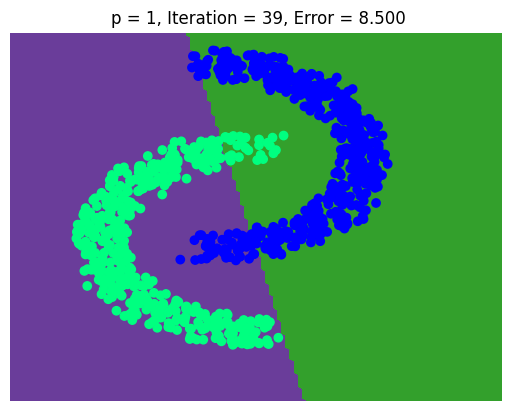

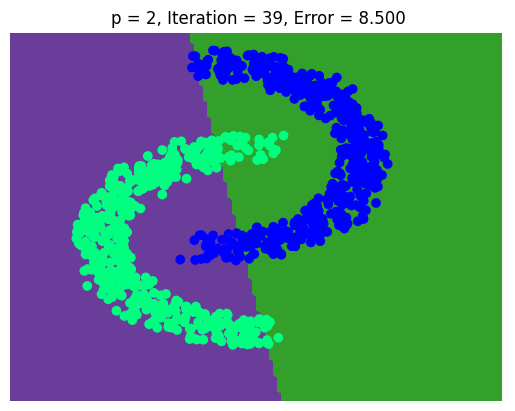

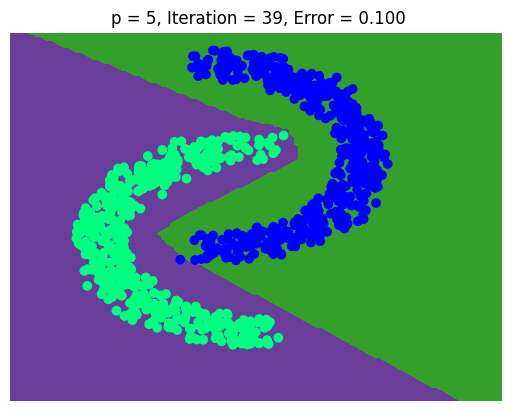

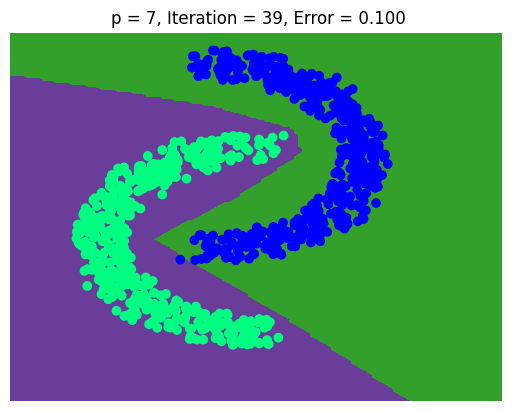

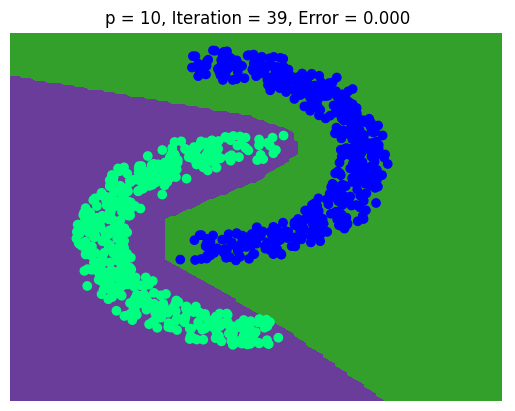

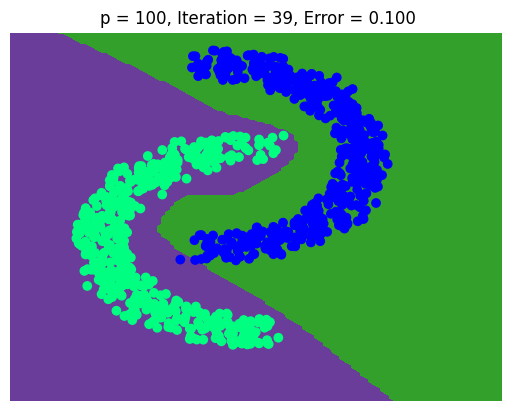

In [22]:
for h in hidden_units:
    print(f"# Training with {h} hidden units")

    # Run train_loop with visualization set to 'last' to only plot at the end of training
    tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='last', nEpochs=nEpochs)


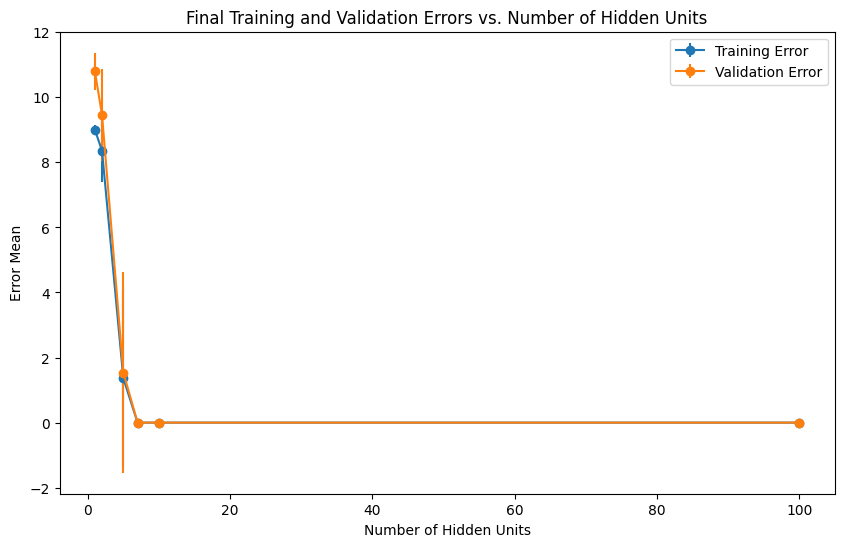

In [14]:
# Plotting final error mean with standard deviation for training and validation sets
plt.figure(figsize=(10, 6))
plt.errorbar(hidden_units, train_mean_errors, yerr=train_std_errors, fmt='-o', label="Training Error")
plt.errorbar(hidden_units, val_mean_errors, yerr=val_std_errors, fmt='-o', label="Validation Error")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Error Mean")
plt.title("Final Training and Validation Errors vs. Number of Hidden Units")
plt.legend()
plt.show()


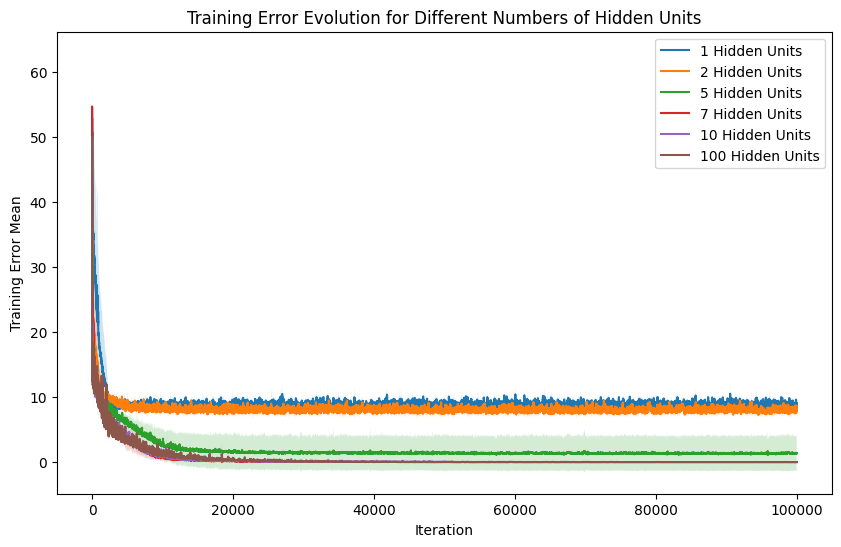

In [17]:
# Mean and std of training error evolution across runs for each hidden unit count
plt.figure(figsize=(10, 6))
for h in hidden_units:
    mean_error_evolution = np.mean(train_error_evolution[h], axis=0)
    std_error_evolution = np.std(train_error_evolution[h], axis=0)
    plt.plot(range(len(mean_error_evolution)), mean_error_evolution, label=f"{h} Hidden Units")
    plt.fill_between(range(len(mean_error_evolution)), mean_error_evolution - std_error_evolution, mean_error_evolution + std_error_evolution, alpha=0.2)

plt.xlabel("Iteration")
plt.ylabel("Training Error Mean")
plt.title("Training Error Evolution for Different Numbers of Hidden Units")
plt.legend()
plt.show()


######################

### Analysis of Training Behavior with Different Numbers of Hidden Units

1. **Training and Validation Errors**: As the number of hidden units increases, the training error tends to decrease. This is expected since a higher number of hidden units provides more capacity for the model to learn complex patterns. However, for very high numbers of units (e.g., 100), validation error may start to increase, indicating potential overfitting.

2. **Convergence Speed**: Models with fewer hidden units tend to converge faster but may not achieve as low an error as those with more hidden units. Larger models take more iterations to converge, and may sometimes not reach zero training error.

3. **Best Configuration**: A moderate number of hidden units (e.g., 5 to 10) often achieves a good balance, minimizing both training and validation error without overfitting.

This analysis suggests that increasing the number of hidden units improves model capacity but can lead to overfitting if the model becomes too complex for the data.


######################

# Part 2 - Building blocks of a CNN

This part introduces typical CNN building blocks, such as ReLU units and linear filters. For a motivation for using CNNs over fully-connected neural networks, see [[Le Cun, et al, 1998]](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).


## Install PyTorch

In [1]:
!pip install torch torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.0+cu121
True


## Convolution

A feed-forward neural network can be thought of as the composition of number of functions
$$
f(\mathbf{x}) = f_L(\dots f_2(f_1(\mathbf{x};\mathbf{w}_1);\mathbf{w}_2)\dots),\mathbf{w}_{L}).
$$
Each function $f_l$ takes as input a datum $\mathbf{x}_l$ and a parameter vector $\mathbf{w}_l$ and produces as output a datum $\mathbf{x}_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\mathbf{w}=(\mathbf{w}_1,\dots,\mathbf{w}_L)$ are *learned from data* in order to solve a target problem, for example classifying images or sounds.

In a *convolutional neural network* data and functions have additional structure. The data $\mathbf{x}_1,\dots,\mathbf{x}_n$ are images, sounds, or more in general maps from a lattice$^1$ to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\mathbf{x}_i$ will be a $M \times N \times K$ real array of $M \times N$ pixels and $K$ channels per pixel. Hence the first two dimensions of the array span space, while the last one spans channels. Note that only the input $\mathbf{x}=\mathbf{x}_1$ of the network is an actual image, while the remaining data are intermediate *feature maps*.

The second property of a CNN is that the functions $f_l$ have a *convolutional structure*. This means that $f_l$ applies to the input map $\mathbf{x}_l$ an operator that is *local and translation invariant*. Examples of convolutional operators are applying a bank of linear filters to $\mathbf{x}_l$.

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular *linear convolution* by a filter bank. We will start by focusing our attention on a single function relation as follows:
$$
 f: \mathbb{R}^{M\times N\times K} \rightarrow \mathbb{R}^{M' \times N' \times K'},
 \qquad \mathbf{x} \mapsto \mathbf{y}.
$$

$^1$A two-dimensional *lattice* is a discrete grid embedded in $R^2$, similar for example to a checkerboard.

(384, 512, 3)


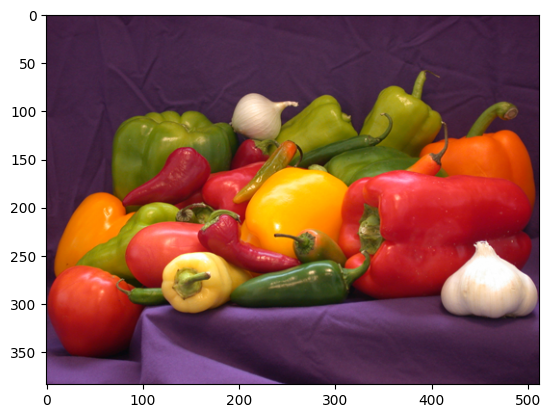

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision

# Download an example image
!wget -q http://www.di.ens.fr/willow/teaching/recvis_orig/assignment3/images/peppers.png
# Read the image
x = np.asarray(Image.open('peppers.png'))/255.0
# Print the size of x. Third dimension (=3) corresponds to the R, G, B channels
print(x.shape)
# Visualize the input x
plt.imshow(x)
# Convert to torch tensor
x = torch.from_numpy(x).permute(2, 0, 1).float()
# Prepare it as a batch
x = x.unsqueeze(0)

This should display an image of bell peppers.

Next, we create a convolutional layer with a bank of 10 filters of dimension $5 \times 5 \times 3$ whose coefficients are initialized randomly. This uses the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) module from PyTorch:

In [3]:
# Create a convolutional layer and a random bank of linear filters
conv = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=0, bias=False)
print(conv.weight.size())

torch.Size([10, 3, 5, 5])


**Remark:** You might have noticed that the `bias` argument to the `torch.nn.Conv2d` function is the empty matrix `false`. It can be otherwise used to pass a vector of bias terms to add to the output of each filter.

Note that `conv.weight` has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume containing three slices. The next step is applying the filter to the image.

In [4]:
# Apply the convolution operator
y = conv(x)
# Observe the input/output sizes
print(x.size())
print(y.size())

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 380, 508])


The variable `y` contains the output of the convolution. Note that the filters are three-dimensional. This is because they operate on a tensor $\mathbf{x}$ with $K$ channels. Furthermore, there are $K'$ such filters, generating a $K'$ dimensional map $\mathbf{y}$.

We can now visualise the output `y` of the convolution. In order to do this, use the `torchvision.utils.make_grid` function to display an image for each feature channel in `y`:

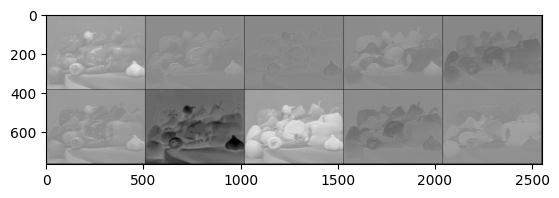

In [5]:
# Visualize the output y
def vis_features(y):
    # Organize it into 10 grayscale images
    out = y.permute(1, 0, 2, 3)
    # Scale between [0, 1]
    out = (out - out.min().expand(out.size())) / (out.max() - out.min()).expand(out.size())
    # Create a grid of images
    out = torchvision.utils.make_grid(out, nrow=5)
    # Convert to numpy image
    out = np.transpose(out.detach().numpy(), (1, 2, 0))
    # Show
    plt.imshow(out)
    # Remove grid
    plt.gca().grid(False)

vis_features(y)

So far filters preserve the resolution of the input feature map. However, it is often useful to *downsample the output*. This can be obtained by using the `stride` option in `torch.nn.Conv2d`:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 24, 32])


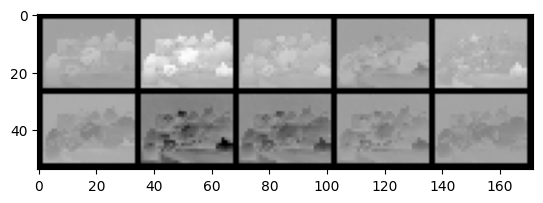

In [6]:
# Try again, downsampling the output
conv_ds = torch.nn.Conv2d(3, 10, kernel_size=5, stride=16, padding=0, bias=False)
y_ds = conv_ds(x)
print(x.size())
print(y_ds.size())
vis_features(y_ds)

Applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the `pad` option:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 384, 512])


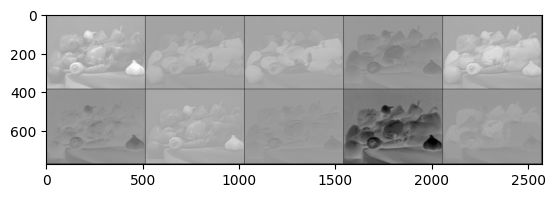

In [7]:
# Try padding
conv_pad = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2, bias=False)
y_pad = conv_pad(x)
print(x.size())
print(y_pad.size())
vis_features(y_pad)

In order to consolidate what has been learned so far, we will now design a filter by hand:


torch.Size([1, 3, 384, 512])
torch.Size([1, 1, 384, 512])


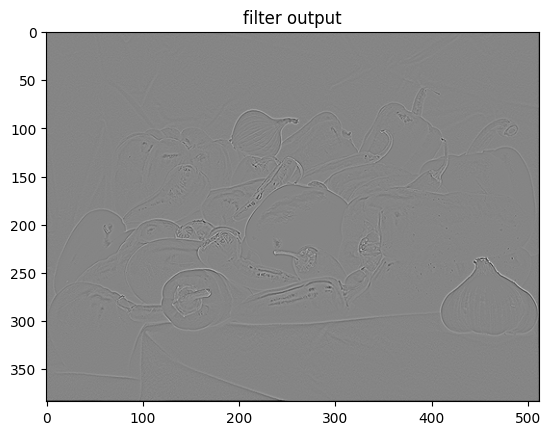

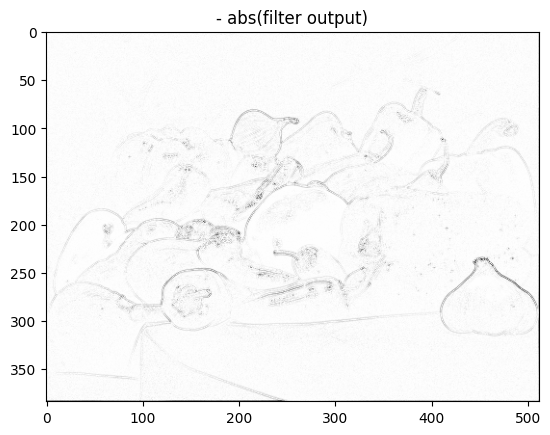

In [8]:
w = torch.FloatTensor([[0,  1, 0 ],
                      [1, -4, 1 ],
                      [0,  1, 0 ]])
w = w.repeat(3, 1).reshape(1, 3, 3, 3)
conv_lap = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
conv_lap.weight = torch.nn.Parameter(w)
y_lap = conv_lap(x)
print(x.size())
print(y_lap.size())

plt.figure()
vis_features(y_lap)
plt.title('filter output')

plt.figure()
vis_features(-torch.abs(y_lap))
plt.title('- abs(filter output)') ;


### :: TASK 2.1 ::
* i. What filter have we implemented?
* ii. How are the RGB colour channels processed by this filter?
* iii. What image structure are detected?

######################


**(i) What filter have we implemented?**

We have implemented a **Laplacian filter**, commonly used for edge detection. This filter emphasizes areas with rapid intensity changes by applying a second derivative operation, highlighting edges in the image.

**(ii) How are the RGB color channels processed by this filter?**

The filter is applied separately to each RGB color channel. By repeating the kernel across channels (`w.repeat(3, 1)`), the same edge-detection operation is performed on each color channel independently, resulting in three filtered output channels corresponding to R, G, and B.

**(iii) What image structures are detected?**

The Laplacian filter detects **edges** and areas of sharp intensity transitions. This makes it effective for identifying boundaries and outlines of objects, as it highlights regions with high contrast in the original image.







######################


## Non-linear activation functions

The simplest non-linearity is obtained by following a linear filter by a *non-linear activation function*, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the *Rectified Linear Unit (ReLU)*
$$
  y_{ijk} = \max\{0, x_{ijk}\}.
$$
This function is implemented by [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU). Run the code below and understand what the filter $\mathbf{w}$ is doing.


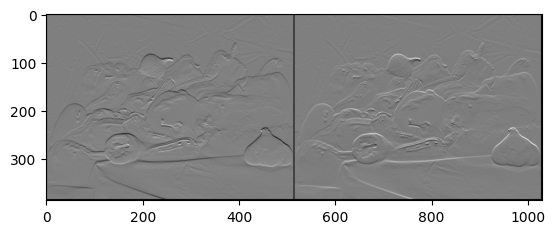

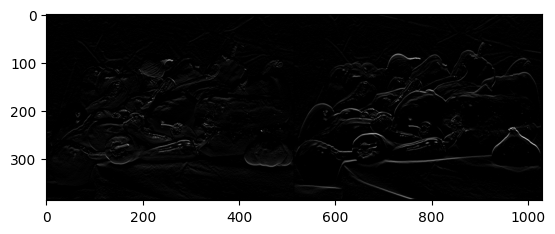

In [9]:
w = torch.FloatTensor([[1], [0], [-1]]).repeat(1, 3, 1, 1)
w = torch.cat((w, -w), 0)

conv = torch.nn.Conv2d(3, 2, kernel_size=(3, 1), stride=1, padding=0, bias=False)
conv.weight = torch.nn.Parameter(w)
relu = torch.nn.ReLU()

y = conv(x)
z = relu(y)

plt.figure()
vis_features(y)
plt.figure()
vis_features(z)

## Pooling
There are several other important operators in a CNN. One of them is *pooling*.  A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, *max-pooling* is defined as:
$$
   y_{ijk} = \max \{ y_{i'j'k} : i \leq i' < i+p, j \leq j' < j + p \}
$$
Max-pooling is implemented by [`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d).

### :: TASK 2.2 ::

Run the code below to try max-pooling. Look at the resulting image. Can you interpret the result?

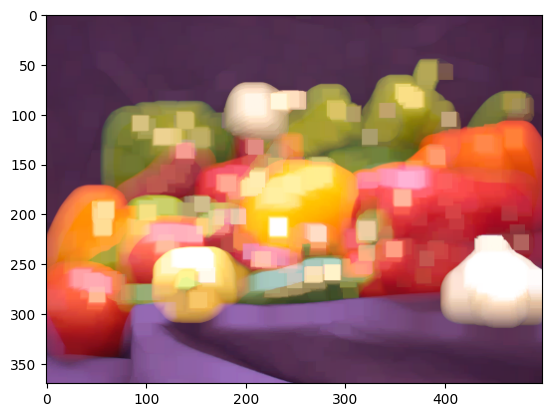

In [10]:
mp = torch.nn.MaxPool2d(15, stride=1)
y = mp(x)
plt.imshow(y.squeeze().permute(1, 2, 0).numpy())
plt.gca().grid(False)

######################


After running the max-pooling operation with a kernel size of 15 and a stride of 1, the resulting image appears with fewer details and a blockier structure. Here’s what is happening:

**Interpretation of the Result:**
1. **Pooling Effect**: Max-pooling with a large kernel (15x15) takes the maximum value within each 15x15 region of the image. Since the stride is 1, the max-pooling window moves one pixel at a time, but each output pixel represents the maximum intensity in its neighborhood.
   
2. **Reduced Detail and Enhanced Prominent Features**: This operation removes fine-grained details and highlights the most prominent features or highest intensity values within each region. Consequently, the output image shows "blockier" shapes, with smoother transitions and a focus on dominant structures over small textures.

3. **Feature Coalescing**: Max-pooling coalesces (groups) nearby features, making the output less sensitive to small variations in pixel intensity, which is useful in CNNs for reducing the spatial dimensions and capturing essential features robustly.

Overall, the image after max-pooling retains key features while reducing smaller details, enhancing the most prominent regions within each pooling window.








######################

# Part 3 - Training a CNN

This part is an introduction to using PyTorch for training simple neural net models. CIFAR-10 dataset will be used.

## Imports

In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

## Parameters

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook.
Unless otherwise specified, use the default values throughout this assignment.

In [12]:
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01         # learning rate

## Warmup





It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
The train/test split is 50k/10k.

In [13]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time,
#          because it will download the dataset from the internet
dataset = 'cifar10'
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

100%|██████████| 170M/170M [00:03<00:00, 45.7MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


### :: TASK 3.1 ::

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images. Display 5 images from the dataset together with their category label. [See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

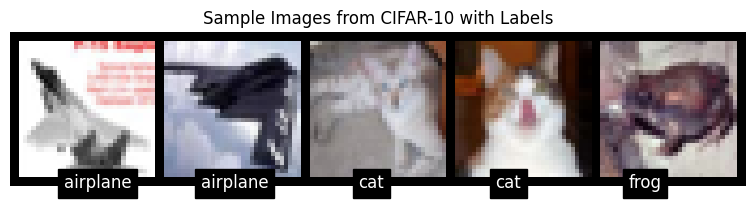

In [16]:
##########################
# CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

data_loader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)
images, labels = next(iter(data_loader))

images = images * 0.5 + 0.5

plt.figure(figsize=(10, 2))
grid_img = torchvision.utils.make_grid(images, nrow=5)
plt.imshow(grid_img.permute(1, 2, 0).numpy())
plt.title("Sample Images from CIFAR-10 with Labels")

for i in range(5):
    label = classes[labels[i]]
    plt.text(i * 32 + 20, 36, label, ha='center', color='white', fontsize=12, backgroundcolor='black')

plt.axis('off')
plt.show()

##########################


## Training a Convolutional Network on CIFAR-10




Start by running the provided training code below. By default it will train on CIFAR-10 for 10 epochs (passes through the training data) with a single layer network. The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. Note the decrease in training loss and corresponding decrease in validation errors.

In [17]:
def train(epoch, network):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [18]:
# Single layer network architecture

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.num_inputs = num_inputs

    def forward(self, input):
        input = input.view(-1, self.num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

In [19]:
# Train
network = Net(3072, 10)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 11):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.337333
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.239533
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.855810
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.946398
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.867337
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.758662
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.737541
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.805470


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.7759, Accuracy: 3906/10000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.834292
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.662476
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.632801
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.983666
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.702210
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.528521
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.699548
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.621580

Test set: Average loss: 1.7636, Accuracy: 3896/10000 (39%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.640559
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.673931
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.631958
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.538750
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.733522
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.618302
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.674191
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.891647

Test set: Average loss: 1.7376, Accuracy: 4081/10000 (41%)

Train Epoch: 4 [0/50000 (0%)]

### :: TASK 3.2 ::

Add code to create a convolutional network architecture as below.

  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

In [21]:
class ConvNet(nn.Module):
    ##########################
    def __init__(self):
          super(ConvNet, self).__init__()

          # Convolution layer 1: 5x5 filters, 16 feature maps + Tanh
          self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
          self.tanh1 = nn.Tanh()

          # Max pooling layer 1: 2x2
          self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Convolution layer 2: 5x5 filters, 128 feature maps + Tanh
          self.conv2 = nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5)
          self.tanh2 = nn.Tanh()

          # Max pooling layer 2: 2x2
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Fully connected layers
          self.fc1 = nn.Linear(128 * 5 * 5, 64)  # Assuming input images are 32x32
          self.tanh3 = nn.Tanh()

          # Output layer: 10 output units (for CIFAR-10's 10 classes)
          self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Convolution layer 1 + Tanh + Max Pooling
        x = self.conv1(x)
        x = self.tanh1(x)
        x = self.pool1(x)

        # Convolution layer 2 + Tanh + Max Pooling
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.pool2(x)

        # Flatten to a vector
        x = x.view(-1, 128 * 5 * 5)

        # Fully connected layer 1 + Tanh
        x = self.fc1(x)
        x = self.tanh3(x)

        # Output layer
        x = self.fc2(x)

        return x
    ##########################

### :: TASK 3.3 ::

Some of the functions in a CNN must be non-linear. Why?





######################


1. **Enabling Complex Representations**: Without non-linear activation functions (like ReLU, Tanh, etc.), a CNN would effectively be equivalent to a single linear transformation. This means that stacking multiple layers without non-linearities would result in a network that behaves like a single-layer linear model, limiting its ability to learn complex patterns. Non-linear functions allow the network to model complex, non-linear relationships within the data.

2. **Feature Hierarchies**: Non-linear functions enable the network to learn hierarchical feature representations. In CNNs, earlier layers capture simpler features (like edges), while deeper layers combine these to detect more complex patterns (like shapes and objects). Non-linearities between layers make it possible to capture these progressively abstract representations.

3. **Introducing Flexibility in Decision Boundaries**: In tasks such as image classification, non-linearities allow the network to learn flexible decision boundaries that can better separate classes in high-dimensional feature space. This is especially important for distinguishing complex image patterns that cannot be separated linearly.


######################

### :: TASK 3.4 ::
Train the CNN for 20 epochs on the CIFAR-10 training set.



In [22]:
# Train
network=ConvNet()
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 21):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.312097
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.201764
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.145070
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.860643
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.924351
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.890313
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.852278
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.811885

Test set: Average loss: 1.8010, Accuracy: 3785/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.819764
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.742162
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.774397
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.722957
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.740393
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.780059
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.544717
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.567630

Test set: Average loss: 1.6156, Accuracy: 4271/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.760712
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.449

### :: TASK 3.5 ::
Plot the first convolutional layer weights as images after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )


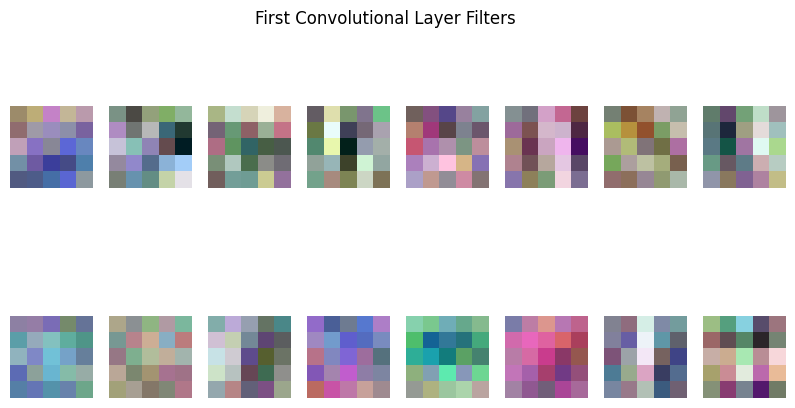

In [23]:
##########################
first_layer_weights = network.conv1.weight.data.clone()

min_wt = first_layer_weights.min()
max_wt = first_layer_weights.max()
normalized_weights = (first_layer_weights - min_wt) / (max_wt - min_wt)

plt.figure(figsize=(10, 5))
num_filters = normalized_weights.shape[0]
for i in range(num_filters):
    plt.subplot(2, 8, i + 1)
    filter_img = normalized_weights[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(filter_img)
    plt.axis('off')

plt.suptitle("First Convolutional Layer Filters")
plt.show()

##########################

### :: TASK 3.6 ::

What is the dimensionality of the weights at each layer? How many parameters are there in total in this CNN architecture?

######################

#### 1. Dimensionality of the Weights at Each Layer

Let's calculate the dimensionality of weights in each layer of the CNN architecture:

- **First Convolutional Layer**:
  - **Filter Size**: 5x5
  - **Input Channels**: 3 (RGB channels)
  - **Output Channels**: 16
  - **Weight Dimensions**: $(16, 3, 5, 5)$ (16 filters of size 5x5 applied to 3 channels)
  - **Bias Dimensions**: $(16)$
  - **Number of Parameters**: $16 \times 3 \times 5 \times 5 + 16 = 1216$

- **Second Convolutional Layer**:
  - **Filter Size**: 5x5
  - **Input Channels**: 16 (output of the first convolutional layer)
  - **Output Channels**: 128
  - **Weight Dimensions**: $(128, 16, 5, 5)$ (128 filters of size 5x5 applied to 16 channels)
  - **Bias Dimensions**: $(128)$
  - **Number of Parameters**: $128 \times 16 \times 5 \times 5 + 128 = 51328$

- **First Fully Connected Layer**:
  - **Input Units**: 128 feature maps of size 5x5 (from the previous max-pooling layer), which results in $128 \times 5 \times 5 = 3200$ inputs.
  - **Output Units**: 64
  - **Weight Dimensions**: $(64, 3200)$
  - **Bias Dimensions**: $(64)$
  - **Number of Parameters**: $64 \times 3200 + 64 = 204864$

- **Second Fully Connected Layer (Output Layer)**:
  - **Input Units**: 64 (from the previous fully connected layer)
  - **Output Units**: 10 (one for each CIFAR-10 class)
  - **Weight Dimensions**: $(10, 64)$
  - **Bias Dimensions**: $(10)$
  - **Number of Parameters**: $10 \times 64 + 10 = 650$

#### 2. Total Number of Parameters in the CNN

Now, summing up the parameters from each layer:

- First Convolutional Layer: $1216$
- Second Convolutional Layer: $51328$
- First Fully Connected Layer: $204864$
- Second Fully Connected Layer: $650$

**Total Parameters** = $1216 + 51328 + 204864 + 650 = 258058$

### Summary

- **First Convolutional Layer**: $1216$ parameters
- **Second Convolutional Layer**: $51,328$ parameters
- **First Fully Connected Layer**: $204,864$ parameters
- **Second Fully Connected Layer**: $650$ parameters
- **Total Parameters**: **258,058** parameters

This total represents the number of learnable weights in the CNN, which determines the model's capacity and complexity.

######################



## Useful resources

  - [PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)
  - [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

## AUTHORSHIP STATEMENT

I declare that the preceding work was the sole result of my own effort and that I have not used any code or results from third-parties.

Julien Delavande